In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip facial-keypoints-detection

Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import cv2
import glob as gb
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  

In [ ]:
with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
# Load the training dataset into memory
train_data = pd.read_csv('data/training.csv')
train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [ ]:

# test data
test_data = pd.read_csv('data/test.csv')
test_data.head()


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
train_data.shape

(7049, 31)

In [ ]:

# check the number of missing values
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:

# using ffill to fill the missing values
train_data.fillna(method='ffill', inplace=True)

In [ ]:
# check the number of missing values
train_data.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [ ]:

## Analysis of the Images
# %%
im_width, im_height = 96, 96

# %%
# checking the data type of the image column
type(train_data['Image'][0])

str

In [ ]:

# convert the image column to numpy array
train_data['Image'] = train_data['Image'].apply(lambda x: np.fromstring(x, sep=' '))

In [ ]:

img = []

for i in range(0, 7049):
    img_pixel = train_data['Image'][i].reshape(im_width, im_height)
    img.append(img_pixel)

# %%
# convert the list to numpy array
img = np.array(img)

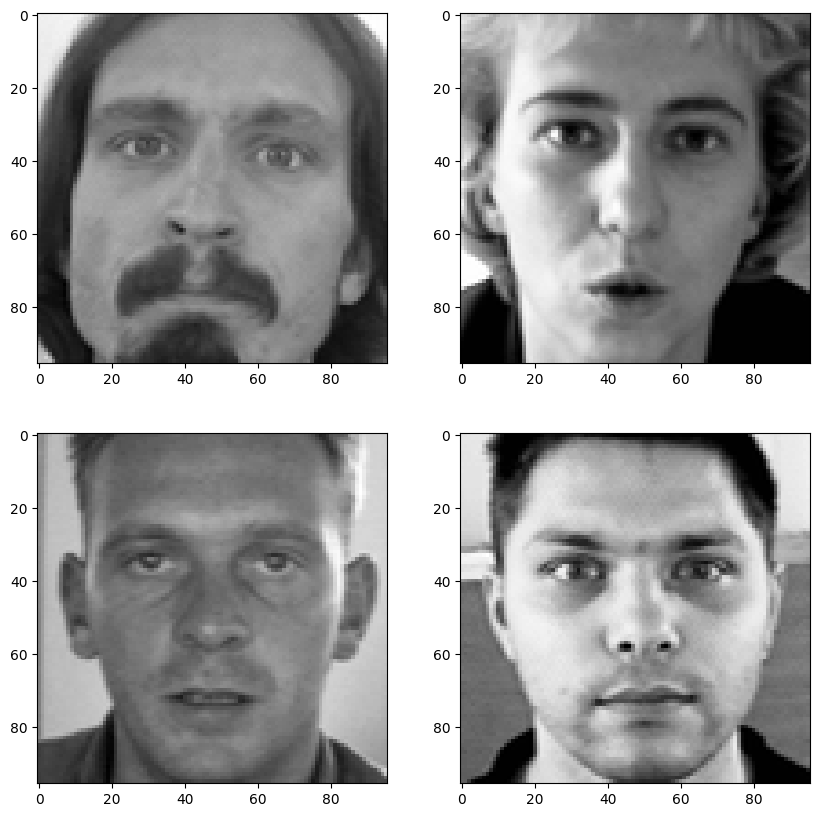

In [ ]:

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img[0], cmap='gray')
ax[0, 1].imshow(img[1], cmap='gray')
ax[1, 0].imshow(img[2], cmap='gray')
ax[1, 1].imshow(img[3], cmap='gray')

In [ ]:

from sklearn.model_selection import train_test_split

In [ ]:

# separate the features and labels
X = img
y = train_data.drop(['Image'], axis=1)

# %%
# split the data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# %%
# convert the data to float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# %%
# normalize the data
X_train /= 255
X_val /= 255

# %%
# reshape the data
X_train = X_train.reshape(-1, 96, 96, 1)
X_val = X_val.reshape(-1, 96, 96, 1)

In [ ]:

# check the shape of the data
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5639, 96, 96, 1), (1410, 96, 96, 1), (5639, 30), (1410, 30))

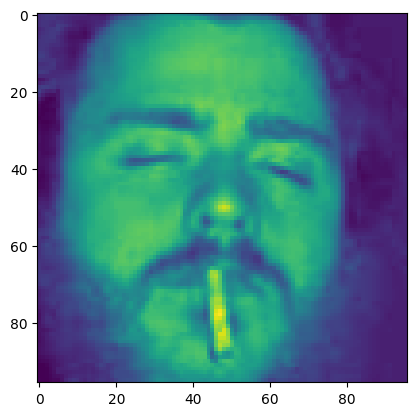

In [ ]:
plt.imshow(X_train[1500])
plt.show()

In [ ]:
import random

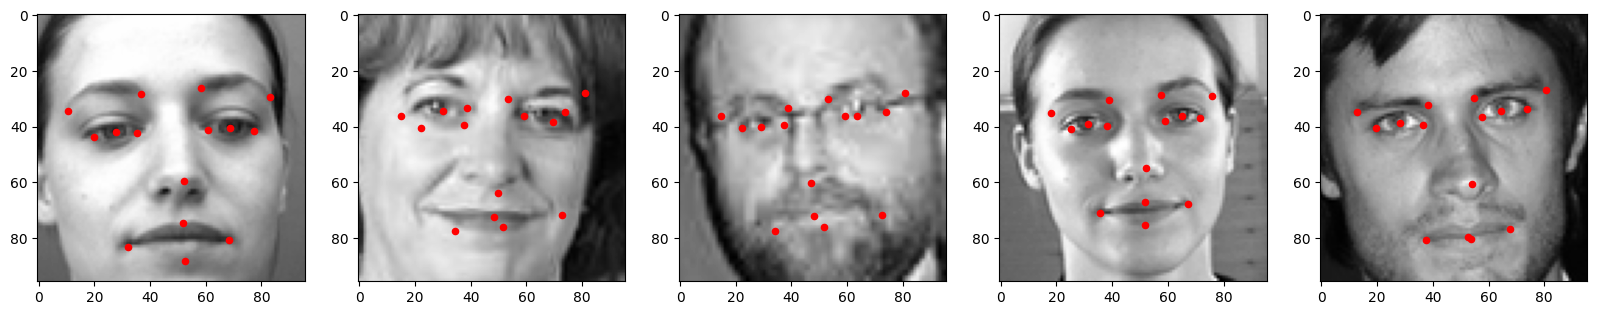

In [ ]:
# face keypoints
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], marker='o', s=20, c='r')

# %%
plt.figure(figsize=(20, 10))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    show_keypoints(X_train[i], y_train.iloc[i])



In [ ]:

# define the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(30)
])

# %%
# compile the model
model.compile(optimizer='adam',
                loss='mean_squared_error',          
                metrics=['mae'])

# %%
# define the callbacks
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


In [ ]:
# train the model
history = model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint, earlystop], validation_data=(X_val, y_val))

Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 188.8326 - mae: 8.3285

177/177 [==============================] - 17s 24ms/step - loss: 188.8326 - mae: 8.3285 - val_loss: 12.7680 - val_mae: 2.5277
Epoch 2/100
173/177 [============================>.] - ETA: 0s - loss: 13.7887 - mae: 2.6082

177/177 [==============================] - 4s 21ms/step - loss: 13.7860 - mae: 2.6091 - val_loss: 10.5964 - val_mae: 2.1879
Epoch 3/100
177/177 [==============================] - 2s 12ms/step - loss: 13.1664 - mae: 2.5296 - val_loss: 11.7410 - val_mae: 2.3992
Epoch 4/100
172/177 [============================>.] - ETA: 0s - loss: 13.3583 - mae: 2.5423

177/177 [==============================] - 3s 19ms/step - loss: 13.2866 - mae: 2.5370 - val_loss: 9.9756 - val_mae: 2.0117
Epoch 5/100
177/177 [==============================] - ETA: 0s - loss: 13.3696 - mae: 2.5431

177/177 [==============================] - 3s 17ms/step - loss: 13.3696 - mae: 2.5431 - val_loss: 9.7628 - val_mae: 2.0268
Epoch 6/100
177/177 [==============================] - 2s 11ms/step - loss: 13.2287 - mae: 2.5297 - val_loss: 9.9214 - val_mae: 2.0497
Epoch 7/100
177/177 [==============================] - 2s 12ms/step - loss: 12.6190 - mae: 2.4369 - val_loss: 13.5545 - val_mae: 2.7103
Epoch 8/100
177/177 [==============================] - 2s 11ms/step - loss: 13.0611 - mae: 2.5193 - val_loss: 10.1412 - val_mae: 2.0956
Epoch 9/100
177/177 [==============================] - 2s 11ms/step - loss: 12.3970 - mae: 2.4159 - val_loss: 12.2953 - val_mae: 2.3471
Epoch 10/100
177/177 [==============================] - 2s 10ms/step - loss: 13.4120 - mae: 2.5454 - val_loss: 11.1570 - val_mae: 2.1857
Epoch 11/100
177/177 [==============================] - 2s 11ms/step - loss: 12.9162 - mae: 2.4808 - val_loss: 13.6694 - val_mae: 2.7263
Epoch 12/100
175/177 [============================>.] - ETA:

177/177 [==============================] - 3s 19ms/step - loss: 12.0655 - mae: 2.3843 - val_loss: 9.5897 - val_mae: 1.9999
Epoch 13/100
177/177 [==============================] - 2s 11ms/step - loss: 12.1430 - mae: 2.3822 - val_loss: 9.7377 - val_mae: 1.9121
Epoch 14/100
177/177 [==============================] - 2s 11ms/step - loss: 12.3291 - mae: 2.4033 - val_loss: 13.7105 - val_mae: 2.5916
Epoch 15/100
173/177 [============================>.] - ETA: 0s - loss: 12.4658 - mae: 2.4293

177/177 [==============================] - 3s 17ms/step - loss: 12.4578 - mae: 2.4305 - val_loss: 9.5136 - val_mae: 1.9518
Epoch 16/100
173/177 [============================>.] - ETA: 0s - loss: 12.3361 - mae: 2.4071

177/177 [==============================] - 3s 18ms/step - loss: 12.2798 - mae: 2.4024 - val_loss: 9.3090 - val_mae: 1.9215
Epoch 17/100
177/177 [==============================] - 2s 11ms/step - loss: 12.4751 - mae: 2.4339 - val_loss: 11.6941 - val_mae: 2.2924
Epoch 18/100
177/177 [==============================] - 2s 12ms/step - loss: 12.1972 - mae: 2.3899 - val_loss: 11.5597 - val_mae: 2.3658
Epoch 19/100
177/177 [==============================] - 2s 11ms/step - loss: 11.8210 - mae: 2.3412 - val_loss: 16.4397 - val_mae: 3.1236
Epoch 20/100
177/177 [==============================] - 2s 11ms/step - loss: 12.4411 - mae: 2.4272 - val_loss: 9.4579 - val_mae: 1.8684
Epoch 21/100
177/177 [==============================] - 2s 11ms/step - loss: 11.8305 - mae: 2.3510 - val_loss: 9.4599 - val_mae: 2.0184
Epoch 22/100
173/177 [============================>.] - ETA: 0s - loss: 11.5545 - mae: 2.2961

177/177 [==============================] - 3s 19ms/step - loss: 11.5354 - mae: 2.2957 - val_loss: 9.2733 - val_mae: 1.9467
Epoch 23/100
173/177 [============================>.] - ETA: 0s - loss: 11.4884 - mae: 2.2890

177/177 [==============================] - 4s 20ms/step - loss: 11.4472 - mae: 2.2843 - val_loss: 9.2043 - val_mae: 1.8337
Epoch 24/100
177/177 [==============================] - 2s 11ms/step - loss: 11.5964 - mae: 2.3169 - val_loss: 9.4552 - val_mae: 1.9049
Epoch 25/100
177/177 [==============================] - 2s 10ms/step - loss: 11.8016 - mae: 2.3510 - val_loss: 9.2441 - val_mae: 1.8462
Epoch 26/100
177/177 [==============================] - 2s 10ms/step - loss: 11.4964 - mae: 2.3197 - val_loss: 9.9526 - val_mae: 2.0735
Epoch 27/100
177/177 [==============================] - 2s 11ms/step - loss: 11.4347 - mae: 2.2980 - val_loss: 9.6253 - val_mae: 1.9691
Epoch 28/100
177/177 [==============================] - 2s 12ms/step - loss: 11.6653 - mae: 2.3322 - val_loss: 10.1763 - val_mae: 2.0375
Epoch 29/100
176/177 [============================>.] - ETA: 0s - loss: 11.3423 - mae: 2.2908

177/177 [==============================] - 3s 18ms/step - loss: 11.3409 - mae: 2.2909 - val_loss: 9.1510 - val_mae: 1.9276
Epoch 30/100
177/177 [==============================] - 2s 11ms/step - loss: 11.5836 - mae: 2.3342 - val_loss: 9.6169 - val_mae: 2.0131
Epoch 31/100
177/177 [==============================] - 2s 11ms/step - loss: 11.1119 - mae: 2.2609 - val_loss: 9.5472 - val_mae: 2.0508
Epoch 32/100
175/177 [============================>.] - ETA: 0s - loss: 10.9819 - mae: 2.2425

177/177 [==============================] - 3s 17ms/step - loss: 10.9588 - mae: 2.2403 - val_loss: 8.5171 - val_mae: 1.7566
Epoch 33/100
176/177 [============================>.] - ETA: 0s - loss: 10.9190 - mae: 2.2576

177/177 [==============================] - 4s 22ms/step - loss: 10.9189 - mae: 2.2578 - val_loss: 8.3635 - val_mae: 1.7075
Epoch 34/100
177/177 [==============================] - ETA: 0s - loss: 10.7342 - mae: 2.2332

177/177 [==============================] - 3s 19ms/step - loss: 10.7342 - mae: 2.2332 - val_loss: 7.8974 - val_mae: 1.6530
Epoch 35/100
177/177 [==============================] - 2s 11ms/step - loss: 10.7122 - mae: 2.2272 - val_loss: 8.0567 - val_mae: 1.8222
Epoch 36/100
177/177 [==============================] - 2s 11ms/step - loss: 10.1954 - mae: 2.1620 - val_loss: 13.7659 - val_mae: 2.8257
Epoch 37/100
177/177 [==============================] - ETA: 0s - loss: 10.4276 - mae: 2.2110

177/177 [==============================] - 4s 20ms/step - loss: 10.4276 - mae: 2.2110 - val_loss: 7.4362 - val_mae: 1.6390
Epoch 38/100
177/177 [==============================] - 2s 12ms/step - loss: 10.1715 - mae: 2.1751 - val_loss: 8.9978 - val_mae: 2.0647
Epoch 39/100
176/177 [============================>.] - ETA: 0s - loss: 10.0351 - mae: 2.1501

177/177 [==============================] - 3s 18ms/step - loss: 10.0402 - mae: 2.1511 - val_loss: 7.1615 - val_mae: 1.6062
Epoch 40/100
177/177 [==============================] - 2s 11ms/step - loss: 9.8774 - mae: 2.1484 - val_loss: 8.1188 - val_mae: 1.8625
Epoch 41/100
177/177 [==============================] - 2s 11ms/step - loss: 9.7526 - mae: 2.1321 - val_loss: 7.5835 - val_mae: 1.7082
Epoch 42/100
177/177 [==============================] - 2s 11ms/step - loss: 9.2781 - mae: 2.0719 - val_loss: 8.1076 - val_mae: 1.8561
Epoch 43/100
177/177 [==============================] - 2s 13ms/step - loss: 9.2983 - mae: 2.0847 - val_loss: 7.3812 - val_mae: 1.7189
Epoch 44/100
177/177 [==============================] - ETA: 0s - loss: 9.4364 - mae: 2.1078

177/177 [==============================] - 3s 19ms/step - loss: 9.4364 - mae: 2.1078 - val_loss: 6.6532 - val_mae: 1.5482
Epoch 45/100
177/177 [==============================] - 2s 11ms/step - loss: 9.2660 - mae: 2.0821 - val_loss: 6.8811 - val_mae: 1.5412
Epoch 46/100
177/177 [==============================] - 2s 11ms/step - loss: 9.0235 - mae: 2.0485 - val_loss: 6.7794 - val_mae: 1.6209
Epoch 47/100
176/177 [============================>.] - ETA: 0s - loss: 8.7622 - mae: 2.0182

177/177 [==============================] - 4s 20ms/step - loss: 8.7574 - mae: 2.0176 - val_loss: 6.3630 - val_mae: 1.5223
Epoch 48/100
177/177 [==============================] - 2s 12ms/step - loss: 9.0138 - mae: 2.0615 - val_loss: 6.5952 - val_mae: 1.6270
Epoch 49/100
177/177 [==============================] - 2s 12ms/step - loss: 8.4831 - mae: 1.9856 - val_loss: 10.4216 - val_mae: 2.4500
Epoch 50/100
177/177 [==============================] - 2s 11ms/step - loss: 8.8828 - mae: 2.0567 - val_loss: 6.7542 - val_mae: 1.6911
Epoch 51/100
172/177 [============================>.] - ETA: 0s - loss: 8.6583 - mae: 2.0040

177/177 [==============================] - 3s 18ms/step - loss: 8.6094 - mae: 2.0004 - val_loss: 6.2021 - val_mae: 1.5180
Epoch 52/100
177/177 [==============================] - 2s 10ms/step - loss: 8.5114 - mae: 2.0007 - val_loss: 6.3477 - val_mae: 1.4827
Epoch 53/100
177/177 [==============================] - ETA: 0s - loss: 8.3006 - mae: 1.9836

177/177 [==============================] - 3s 19ms/step - loss: 8.3006 - mae: 1.9836 - val_loss: 6.0918 - val_mae: 1.4387
Epoch 54/100
176/177 [============================>.] - ETA: 0s - loss: 8.2594 - mae: 1.9643

177/177 [==============================] - 3s 19ms/step - loss: 8.2543 - mae: 1.9637 - val_loss: 6.0644 - val_mae: 1.5032
Epoch 55/100
177/177 [==============================] - 2s 10ms/step - loss: 8.1625 - mae: 1.9535 - val_loss: 6.6437 - val_mae: 1.6983
Epoch 56/100
177/177 [==============================] - ETA: 0s - loss: 8.1303 - mae: 1.9578

177/177 [==============================] - 3s 17ms/step - loss: 8.1303 - mae: 1.9578 - val_loss: 5.7453 - val_mae: 1.4195
Epoch 57/100
177/177 [==============================] - 2s 12ms/step - loss: 7.8535 - mae: 1.9209 - val_loss: 10.3840 - val_mae: 2.4666
Epoch 58/100
177/177 [==============================] - 2s 11ms/step - loss: 8.0943 - mae: 1.9645 - val_loss: 6.5969 - val_mae: 1.6602
Epoch 59/100
173/177 [============================>.] - ETA: 0s - loss: 7.8546 - mae: 1.9404

177/177 [==============================] - 3s 17ms/step - loss: 7.9015 - mae: 1.9419 - val_loss: 5.3509 - val_mae: 1.3887
Epoch 60/100
177/177 [==============================] - 2s 10ms/step - loss: 7.5902 - mae: 1.8888 - val_loss: 6.6371 - val_mae: 1.7738
Epoch 61/100
177/177 [==============================] - 2s 11ms/step - loss: 7.6230 - mae: 1.9019 - val_loss: 5.4268 - val_mae: 1.4354
Epoch 62/100
177/177 [==============================] - 2s 11ms/step - loss: 7.3171 - mae: 1.8574 - val_loss: 7.5762 - val_mae: 2.0115
Epoch 63/100
172/177 [============================>.] - ETA: 0s - loss: 7.2096 - mae: 1.8420

177/177 [==============================] - 3s 19ms/step - loss: 7.2467 - mae: 1.8484 - val_loss: 5.2868 - val_mae: 1.3758
Epoch 64/100
173/177 [============================>.] - ETA: 0s - loss: 7.0319 - mae: 1.8186

177/177 [==============================] - 3s 19ms/step - loss: 7.0393 - mae: 1.8179 - val_loss: 5.1623 - val_mae: 1.3587
Epoch 65/100
177/177 [==============================] - 2s 10ms/step - loss: 7.0020 - mae: 1.8169 - val_loss: 5.6472 - val_mae: 1.5012
Epoch 66/100
177/177 [==============================] - 2s 11ms/step - loss: 7.1183 - mae: 1.8330 - val_loss: 5.4382 - val_mae: 1.4657
Epoch 67/100
177/177 [==============================] - 2s 12ms/step - loss: 7.0440 - mae: 1.8217 - val_loss: 5.6352 - val_mae: 1.5515
Epoch 68/100
177/177 [==============================] - ETA: 0s - loss: 6.6363 - mae: 1.7679

177/177 [==============================] - 3s 18ms/step - loss: 6.6363 - mae: 1.7679 - val_loss: 4.9771 - val_mae: 1.3095
Epoch 69/100
177/177 [==============================] - 2s 11ms/step - loss: 6.6394 - mae: 1.7627 - val_loss: 6.9329 - val_mae: 1.8579
Epoch 70/100
177/177 [==============================] - ETA: 0s - loss: 6.7757 - mae: 1.7983

177/177 [==============================] - 3s 17ms/step - loss: 6.7757 - mae: 1.7983 - val_loss: 4.9749 - val_mae: 1.3377
Epoch 71/100
176/177 [============================>.] - ETA: 0s - loss: 6.3550 - mae: 1.7237

177/177 [==============================] - 3s 18ms/step - loss: 6.3535 - mae: 1.7237 - val_loss: 4.7623 - val_mae: 1.3291
Epoch 72/100
177/177 [==============================] - 2s 12ms/step - loss: 6.4804 - mae: 1.7583 - val_loss: 4.7907 - val_mae: 1.2870
Epoch 73/100
177/177 [==============================] - 2s 11ms/step - loss: 6.4181 - mae: 1.7459 - val_loss: 7.2542 - val_mae: 1.9537
Epoch 74/100
177/177 [==============================] - 2s 11ms/step - loss: 6.3386 - mae: 1.7338 - val_loss: 5.8306 - val_mae: 1.6201
Epoch 75/100
176/177 [============================>.] - ETA: 0s - loss: 6.0104 - mae: 1.6858

177/177 [==============================] - 3s 19ms/step - loss: 6.0177 - mae: 1.6862 - val_loss: 4.6953 - val_mae: 1.3048
Epoch 76/100
177/177 [==============================] - 2s 11ms/step - loss: 6.1123 - mae: 1.6993 - val_loss: 4.7744 - val_mae: 1.2982
Epoch 77/100
177/177 [==============================] - 2s 12ms/step - loss: 6.0172 - mae: 1.6797 - val_loss: 5.1096 - val_mae: 1.4430
Epoch 78/100
177/177 [==============================] - 2s 11ms/step - loss: 6.0198 - mae: 1.6813 - val_loss: 4.9412 - val_mae: 1.3998
Epoch 79/100
177/177 [==============================] - 2s 11ms/step - loss: 5.9369 - mae: 1.6756 - val_loss: 4.7507 - val_mae: 1.2431
Epoch 80/100
177/177 [==============================] - 2s 10ms/step - loss: 5.7340 - mae: 1.6381 - val_loss: 4.7190 - val_mae: 1.3215
Epoch 81/100
176/177 [============================>.] - ETA: 0s - loss: 5.7545 - mae: 1.6486

177/177 [==============================] - 3s 18ms/step - loss: 5.7551 - mae: 1.6488 - val_loss: 4.5010 - val_mae: 1.2514
Epoch 82/100
177/177 [==============================] - 2s 11ms/step - loss: 5.5612 - mae: 1.6193 - val_loss: 4.7689 - val_mae: 1.3586
Epoch 83/100
177/177 [==============================] - 2s 12ms/step - loss: 5.4499 - mae: 1.6053 - val_loss: 4.5766 - val_mae: 1.2969
Epoch 84/100
177/177 [==============================] - 2s 11ms/step - loss: 5.3030 - mae: 1.5697 - val_loss: 5.2400 - val_mae: 1.4657
Epoch 85/100
177/177 [==============================] - 2s 11ms/step - loss: 5.4516 - mae: 1.6036 - val_loss: 4.6374 - val_mae: 1.3176
Epoch 86/100
177/177 [==============================] - 2s 11ms/step - loss: 5.3695 - mae: 1.5876 - val_loss: 4.5734 - val_mae: 1.2380
Epoch 87/100
177/177 [==============================] - ETA: 0s - loss: 5.3205 - mae: 1.5827

177/177 [==============================] - 3s 18ms/step - loss: 5.3205 - mae: 1.5827 - val_loss: 4.3272 - val_mae: 1.1762
Epoch 88/100
177/177 [==============================] - 2s 12ms/step - loss: 5.0929 - mae: 1.5479 - val_loss: 4.4476 - val_mae: 1.2787
Epoch 89/100
177/177 [==============================] - 2s 12ms/step - loss: 5.0438 - mae: 1.5348 - val_loss: 4.5706 - val_mae: 1.3220
Epoch 90/100
177/177 [==============================] - 2s 10ms/step - loss: 4.9021 - mae: 1.5119 - val_loss: 4.3599 - val_mae: 1.2334
Epoch 91/100
177/177 [==============================] - 2s 11ms/step - loss: 4.8537 - mae: 1.5025 - val_loss: 5.3076 - val_mae: 1.5534
Epoch 92/100
177/177 [==============================] - 2s 12ms/step - loss: 4.8207 - mae: 1.5015 - val_loss: 4.5678 - val_mae: 1.2884
Epoch 93/100
177/177 [==============================] - 2s 11ms/step - loss: 4.6452 - mae: 1.4659 - val_loss: 4.5074 - val_mae: 1.2411
Epoch 94/100
175/177 [============================>.] - ETA: 0s - lo

177/177 [==============================] - 4s 20ms/step - loss: 4.6930 - mae: 1.4833 - val_loss: 4.2216 - val_mae: 1.1632
Epoch 95/100
177/177 [==============================] - 2s 11ms/step - loss: 4.5790 - mae: 1.4598 - val_loss: 4.3400 - val_mae: 1.1671
Epoch 96/100
177/177 [==============================] - 2s 11ms/step - loss: 4.5728 - mae: 1.4602 - val_loss: 4.4352 - val_mae: 1.2210
Epoch 97/100
176/177 [============================>.] - ETA: 0s - loss: 4.2807 - mae: 1.4002

177/177 [==============================] - 3s 20ms/step - loss: 4.2799 - mae: 1.4004 - val_loss: 4.1612 - val_mae: 1.1726
Epoch 98/100
177/177 [==============================] - 2s 11ms/step - loss: 4.1621 - mae: 1.3856 - val_loss: 4.2176 - val_mae: 1.1341
Epoch 99/100
177/177 [==============================] - 2s 12ms/step - loss: 4.1646 - mae: 1.3846 - val_loss: 4.2128 - val_mae: 1.2167
Epoch 100/100
177/177 [==============================] - 2s 11ms/step - loss: 4.0854 - mae: 1.3671 - val_loss: 4.2114 - val_mae: 1.1300


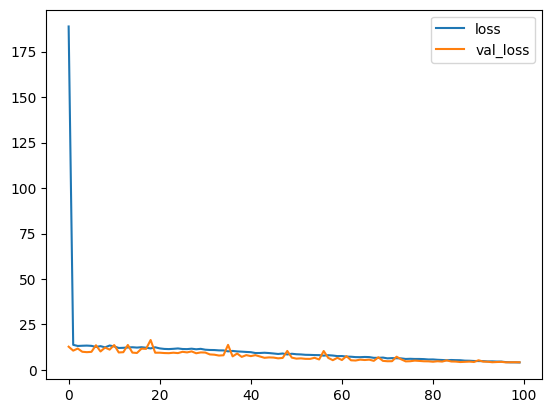

In [ ]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


Epoch 1/100
173/177 [============================>.] - ETA: 0s - loss: 3.9827 - mae: 1.3476

177/177 [==============================] - 3s 19ms/step - loss: 3.9765 - mae: 1.3477 - val_loss: 4.1133 - val_mae: 1.1576
Epoch 2/100
177/177 [==============================] - 2s 12ms/step - loss: 3.8302 - mae: 1.3170 - val_loss: 4.2271 - val_mae: 1.2008
Epoch 3/100
177/177 [==============================] - 3s 16ms/step - loss: 3.7864 - mae: 1.3057 - val_loss: 5.3285 - val_mae: 1.5664
Epoch 4/100
177/177 [==============================] - 3s 16ms/step - loss: 3.6292 - mae: 1.2770 - val_loss: 4.4631 - val_mae: 1.2853
Epoch 5/100
176/177 [============================>.] - ETA: 0s - loss: 3.5941 - mae: 1.2812

177/177 [==============================] - 3s 19ms/step - loss: 3.5936 - mae: 1.2811 - val_loss: 4.0864 - val_mae: 1.1528
Epoch 6/100
177/177 [==============================] - 2s 11ms/step - loss: 3.4132 - mae: 1.2306 - val_loss: 4.1264 - val_mae: 1.1225
Epoch 7/100
174/177 [============================>.] - ETA: 0s - loss: 3.4989 - mae: 1.2553

177/177 [==============================] - 3s 19ms/step - loss: 3.4962 - mae: 1.2552 - val_loss: 3.9902 - val_mae: 1.1223
Epoch 8/100
177/177 [==============================] - 2s 10ms/step - loss: 3.3357 - mae: 1.2246 - val_loss: 4.2057 - val_mae: 1.1425
Epoch 9/100
177/177 [==============================] - 2s 11ms/step - loss: 3.1504 - mae: 1.1747 - val_loss: 4.1275 - val_mae: 1.1629
Epoch 10/100
177/177 [==============================] - 2s 11ms/step - loss: 3.1919 - mae: 1.1884 - val_loss: 4.1195 - val_mae: 1.1627
Epoch 11/100
177/177 [==============================] - ETA: 0s - loss: 3.0500 - mae: 1.1462

177/177 [==============================] - 4s 21ms/step - loss: 3.0500 - mae: 1.1462 - val_loss: 3.9676 - val_mae: 1.1323
Epoch 12/100
175/177 [============================>.] - ETA: 0s - loss: 2.9361 - mae: 1.1271

177/177 [==============================] - 3s 19ms/step - loss: 2.9339 - mae: 1.1267 - val_loss: 3.9112 - val_mae: 1.1143
Epoch 13/100
177/177 [==============================] - 2s 11ms/step - loss: 2.7978 - mae: 1.0942 - val_loss: 4.0484 - val_mae: 1.1462
Epoch 14/100
172/177 [============================>.] - ETA: 0s - loss: 2.7786 - mae: 1.0758

177/177 [==============================] - 3s 18ms/step - loss: 2.7698 - mae: 1.0745 - val_loss: 3.8851 - val_mae: 1.0682
Epoch 15/100
177/177 [==============================] - 2s 11ms/step - loss: 2.7276 - mae: 1.0669 - val_loss: 4.0572 - val_mae: 1.1486
Epoch 16/100
177/177 [==============================] - 2s 12ms/step - loss: 2.6344 - mae: 1.0574 - val_loss: 3.9436 - val_mae: 1.0604
Epoch 17/100
177/177 [==============================] - 2s 11ms/step - loss: 2.5768 - mae: 1.0347 - val_loss: 3.9577 - val_mae: 1.0688
Epoch 18/100
177/177 [==============================] - 2s 11ms/step - loss: 2.5589 - mae: 1.0243 - val_loss: 3.9577 - val_mae: 1.1198
Epoch 19/100
172/177 [============================>.] - ETA: 0s - loss: 2.3952 - mae: 0.9895

177/177 [==============================] - 3s 17ms/step - loss: 2.3862 - mae: 0.9884 - val_loss: 3.8574 - val_mae: 1.1230
Epoch 20/100
177/177 [==============================] - 2s 10ms/step - loss: 2.3823 - mae: 0.9760 - val_loss: 4.0972 - val_mae: 1.0539
Epoch 21/100
174/177 [============================>.] - ETA: 0s - loss: 2.2472 - mae: 0.9517

177/177 [==============================] - 4s 22ms/step - loss: 2.2445 - mae: 0.9514 - val_loss: 3.8127 - val_mae: 1.0328
Epoch 22/100
177/177 [==============================] - ETA: 0s - loss: 2.2713 - mae: 0.9505

177/177 [==============================] - 3s 19ms/step - loss: 2.2713 - mae: 0.9505 - val_loss: 3.7109 - val_mae: 1.0333
Epoch 23/100
177/177 [==============================] - ETA: 0s - loss: 2.2651 - mae: 0.9509

177/177 [==============================] - 3s 19ms/step - loss: 2.2651 - mae: 0.9509 - val_loss: 3.6982 - val_mae: 1.0380
Epoch 24/100
177/177 [==============================] - 2s 11ms/step - loss: 2.1630 - mae: 0.9291 - val_loss: 3.8072 - val_mae: 1.0638
Epoch 25/100
177/177 [==============================] - 2s 11ms/step - loss: 2.1674 - mae: 0.9151 - val_loss: 3.7674 - val_mae: 1.0588
Epoch 26/100
172/177 [============================>.] - ETA: 0s - loss: 2.0429 - mae: 0.9028

177/177 [==============================] - 4s 20ms/step - loss: 2.0371 - mae: 0.9029 - val_loss: 3.6771 - val_mae: 1.0062
Epoch 27/100
177/177 [==============================] - 2s 12ms/step - loss: 2.0746 - mae: 0.9056 - val_loss: 3.7893 - val_mae: 1.0518
Epoch 28/100
177/177 [==============================] - 2s 11ms/step - loss: 1.9884 - mae: 0.8819 - val_loss: 3.8156 - val_mae: 1.0852
Epoch 29/100
177/177 [==============================] - 2s 11ms/step - loss: 2.0311 - mae: 0.9039 - val_loss: 3.7020 - val_mae: 1.0018
Epoch 30/100
177/177 [==============================] - 2s 11ms/step - loss: 1.8828 - mae: 0.8624 - val_loss: 3.6913 - val_mae: 0.9989
Epoch 31/100
176/177 [============================>.] - ETA: 0s - loss: 1.8854 - mae: 0.8517

177/177 [==============================] - 4s 22ms/step - loss: 1.8853 - mae: 0.8517 - val_loss: 3.5896 - val_mae: 0.9874
Epoch 32/100
177/177 [==============================] - 2s 12ms/step - loss: 1.9677 - mae: 0.8678 - val_loss: 3.8283 - val_mae: 1.0192
Epoch 33/100
177/177 [==============================] - 2s 11ms/step - loss: 1.8943 - mae: 0.8633 - val_loss: 3.6775 - val_mae: 1.0068
Epoch 34/100
177/177 [==============================] - 2s 14ms/step - loss: 1.9698 - mae: 0.8679 - val_loss: 3.6494 - val_mae: 1.0064
Epoch 35/100
177/177 [==============================] - 2s 12ms/step - loss: 1.7783 - mae: 0.8354 - val_loss: 3.6219 - val_mae: 0.9668
Epoch 36/100
177/177 [==============================] - 2s 12ms/step - loss: 1.8415 - mae: 0.8391 - val_loss: 3.6798 - val_mae: 1.0173
Epoch 37/100
172/177 [============================>.] - ETA: 0s - loss: 1.6946 - mae: 0.8267

177/177 [==============================] - 3s 18ms/step - loss: 1.7443 - mae: 0.8291 - val_loss: 3.5638 - val_mae: 0.9749
Epoch 38/100
177/177 [==============================] - 2s 11ms/step - loss: 1.6366 - mae: 0.7905 - val_loss: 3.7588 - val_mae: 1.0585
Epoch 39/100
177/177 [==============================] - 2s 11ms/step - loss: 2.1407 - mae: 0.9174 - val_loss: 3.6664 - val_mae: 0.9831
Epoch 40/100
177/177 [==============================] - 2s 11ms/step - loss: 1.8808 - mae: 0.8546 - val_loss: 3.6989 - val_mae: 0.9886
Epoch 41/100
177/177 [==============================] - 2s 12ms/step - loss: 1.8540 - mae: 0.8382 - val_loss: 3.7224 - val_mae: 0.9776
Epoch 42/100
177/177 [==============================] - 2s 12ms/step - loss: 1.8603 - mae: 0.8294 - val_loss: 3.7872 - val_mae: 0.9782
Epoch 43/100
177/177 [==============================] - 2s 11ms/step - loss: 1.7076 - mae: 0.7996 - val_loss: 3.7114 - val_mae: 1.0293
Epoch 44/100
173/177 [============================>.] - ETA: 0s - lo

177/177 [==============================] - 3s 17ms/step - loss: 1.7049 - mae: 0.8168 - val_loss: 3.5064 - val_mae: 0.9506
Epoch 45/100
177/177 [==============================] - 2s 11ms/step - loss: 1.6525 - mae: 0.8018 - val_loss: 3.5931 - val_mae: 0.9486
Epoch 46/100
177/177 [==============================] - 2s 11ms/step - loss: 1.5609 - mae: 0.7720 - val_loss: 3.5670 - val_mae: 0.9443
Epoch 47/100
177/177 [==============================] - 2s 12ms/step - loss: 1.5228 - mae: 0.7635 - val_loss: 3.7277 - val_mae: 0.9764
Epoch 48/100
177/177 [==============================] - 2s 11ms/step - loss: 1.5462 - mae: 0.7697 - val_loss: 3.6559 - val_mae: 0.9440
Epoch 49/100
177/177 [==============================] - 2s 11ms/step - loss: 1.5243 - mae: 0.7580 - val_loss: 3.5649 - val_mae: 0.9313
Epoch 50/100
177/177 [==============================] - 2s 11ms/step - loss: 1.5604 - mae: 0.7713 - val_loss: 3.6212 - val_mae: 0.9214
Epoch 51/100
177/177 [==============================] - 2s 11ms/step

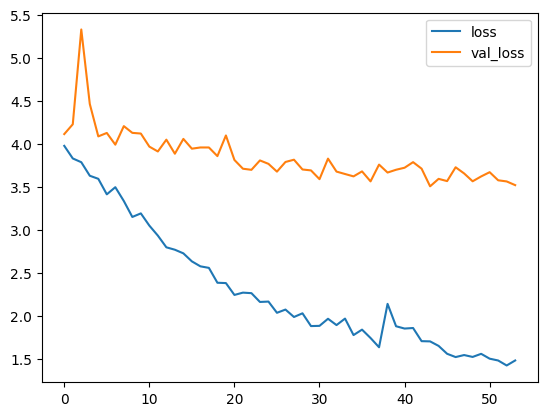

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [ ]:
"""
train the model show the results like accuracy, precision, DSC score in graphs and then test the model and show the SEGMENTED IMAGE visually showing the segmented area in the image
"""

# %%
# train the model
history = model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint, earlystop], validation_data=(X_val, y_val))


# accuracy, precision, DSC score
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# print the model summary
model.summary()



In [ ]:
# print accuracy of the model
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Test loss: 4.1132988929748535
Test accuracy: 1.1576179265975952


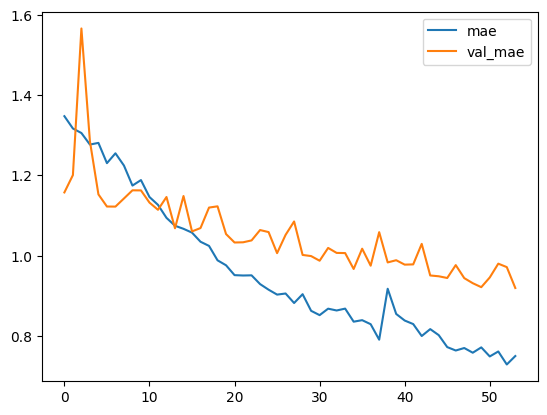

In [ ]:
# %%
# precision, DSC score
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.show()

In [ ]:

# test the model if it can crop the image and show the segmented area
from keras.models import load_model

model = load_model('model-001.model') 
